# Importing dataset

In [73]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import io
import pandas as pd
import cv2
import sklearn
import random
from osgeo import gdal
import shutil

# PATHS

In [74]:
DATA_PATH = "D:/Geoprocessamento/DataSetModelo/l8_biome/"

SCENES_PATH = DATA_PATH + "BC/"

# Utils

In [75]:
def normalize_min_max(image):
    return((image-np.nanmin(image))/(np.nanmax(image)- np.nanmin(image)))

def resize_img(image,x,y,z):
    image = cv2.resize(image,(x,y))
    image = image.reshape((x,y,z))
    return image

def clip_image(r,g,b,n):
    return np.dstack((r,g,b,n))

def print_l8_biome_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

# Separando o dataset em diretórios

In [76]:
# Creating folders
try:
    folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']
    for folder in folders:
        os.makedirs(DATA_PATH + folder)
except:
    pass

In [77]:
#Split dataset files
all_frames = os.listdir(SCENES_PATH)
random.seed(4)
random.shuffle(all_frames,)

train_size = int(0.7 * len(all_frames))
val_size = int(0.15 * len(all_frames))
test_size = int(0.15 * len(all_frames))

train_scene = all_frames[:train_size]
val_scene = all_frames[train_size:train_size+val_size]
test_scene = val_subscenes = all_frames[train_size+val_size:]

In [78]:
# Generate corresponding mask lists for masks
train_masks = [f for f in all_frames if f in train_scene]
val_masks = [f for f in all_frames if f in val_scene]
test_masks = [f for f in all_frames if f in test_scene]


In [79]:
#Add train, val frames and masks to relevant folders
from numpy import save

def add_frames(dir_name, image):
    dir_name = 'D:/Geoprocessamento/DataSetModelo/l8_biome/' + dir_name + '/'
    current_dir_r = SCENES_PATH + image +'/'+ image + '_B3.TIF'
    current_dir_g = SCENES_PATH + image +'/'+ image + '_B2.TIF'
    current_dir_b = SCENES_PATH + image +'/'+ image + '_B1.TIF'
    current_dir_NIR = SCENES_PATH + image +'/'+ image + '_B4.TIF'
    
    r = gdal.Open(current_dir_r).ReadAsArray()
    g = gdal.Open(current_dir_g).ReadAsArray()
    b = gdal.Open(current_dir_b).ReadAsArray()
    n = gdal.Open(current_dir_NIR).ReadAsArray()
    rgbn = clip_image(r,g,b,n)
    
    save(dir_name + image + '.npy', rgbn)
    #shutil.copyfile(current_dir_r, dir_name + image+ '_B3.TIF')
    #shutil.copyfile(current_dir_g, dir_name + image+ '_B2.TIF')
    #shutil.copyfile(current_dir_b, dir_name + image+ '_B1.TIF')
    #shutil.copyfile(current_dir_NIR, dir_name + image+ '_B4.TIF')
    
def add_masks(dir_name, image):
    dir_name = 'D:/Geoprocessamento/DataSetModelo/l8_biome/' + dir_name + '/'
    current_dir_MASK = SCENES_PATH + image +'/'+ image + '_fixedmask.img'
    
    mask = gdal.Open(current_dir_MASK).ReadAsArray()
    save(dir_name + image + '.npy', mask)
    #shutil.copyfile(current_dir_MASK, dir_name + image + '.img')

In [80]:
frame_folders = [(train_scene, 'train_frames'), (val_scene, 'val_frames'), (test_scene, 'test_frames')]

mask_folders = [(train_masks, 'train_masks'), (val_masks, 'val_masks'), (test_masks, 'test_masks')]

In [ ]:
#Celula que carrega as imagens nos diretórios corretos
'''
from PIL import Image

# Add frames
for folder in frame_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    list(map(add_frames, name, array))

# Add masks
for folder in mask_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    list(map(add_masks, name, array))
'''

# Creating the generator

In [81]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format=None,
        )

In [82]:
BATCH_SIZE = 4

train_image_generator = train_datagen.flow_from_directory(
'D:/Geoprocessamento/DataSetModelo/l8_biome/train_frames',
batch_size = BATCH_SIZE)


Found 0 images belonging to 0 classes.


In [83]:
import cv2
import random
from sklearn.model_selection import ParameterGrid


In [84]:
def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)
    x,y,z = 512,512,1
    while(True):
        img = np.zeros((batch_size, 512, 512, 4)).astype('float')
        mask = np.zeros((batch_size, 512, 512, 1)).astype('float')

        for i in range(c, c + batch_size): #initially from 0 to 16, c = 0. 
            train_img = np.load(img_folder+'/'+n[i], allow_pickle=True)
            
            
            train_img =  cv2.resize(train_img, (512, 512))# Read an image from folder and resize
            #train_img = train_img.reshape(512, 512, 4)
            train_img = normalize_min_max(train_img)
            train_img = tf.convert_to_tensor(train_img)
            img[i-c] = train_img #add to array - img[0], img[1], and so on.

            train_mask = (np.load(mask_folder+'/'+n[i]))
            train_mask = (np.load(mask_folder+'/'+n[i]))
            train_mask = train_mask/1
            #train_mask = cv2.resize(train_mask, (512, 512))
            train_mask = resize_img(train_mask,x,y,z)
            train_mask = normalize_min_max(train_mask)
            #train_mask = np.expand_dims(train_mask,axis=2)
            train_mask = tf.convert_to_tensor(train_mask)
            mask[i-c] = train_mask
            

        c += batch_size
        
        if(c + batch_size >= len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                      # print "randomizing again"
        
        yield img, mask

train_frame_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/train_frames'
train_mask_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/train_masks'

val_frame_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/val_frames'
val_mask_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/val_masks'

test_frame_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/test_frames'
test_mask_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/test_masks'

train_gen = data_gen(train_frame_path,train_mask_path, batch_size = BATCH_SIZE)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = BATCH_SIZE)
test_gen = data_gen(test_frame_path,test_mask_path, batch_size = BATCH_SIZE)

# F1 SCORE

In [85]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Creating the model

In [86]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [87]:
NO_OF_TRAINING_IMAGES = len(os.listdir(train_frame_path))
NO_OF_VAL_IMAGES = len(os.listdir(val_frame_path))
weights_path = 'D:/Geoprocessamento/DataSetModelo/l8_biome/'

checkpoint = ModelCheckpoint(weights_path, monitor='f1', 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger('D:/Geoprocessamento/DataSetModelo/l8_biome/log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'f1', verbose = 1,
                              min_delta = 0.01, patience = 20, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]




In [88]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

from itertools import chain
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [89]:
# Build U-Net model

inputs = Input((512, 512, 4))
s = (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy",f1])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 32) 1184        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 512, 512, 32) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 32) 9248        dropout_18[0][0]                 
_______________________________________________________________________________________

### Training

In [91]:
#training the model
model_history = model.fit(train_gen, 
                    epochs = 64, 
                    batch_size = BATCH_SIZE, 
                    validation_data = val_gen, 
                    callbacks = callbacks_list,
                    steps_per_epoch =(NO_OF_TRAINING_IMAGES/BATCH_SIZE), 
                    validation_steps = (NO_OF_VAL_IMAGES/BATCH_SIZE)
                  )

Epoch 1/64
17/16 [===============================] - ETA: -18s - loss: 0.6810 - accuracy: 0.5111 - f1: 0.4947
Epoch 00001: f1 improved from -inf to 0.49469, saving model to D:/Geoprocessamento/DataSetModelo/l8_biome\
INFO:tensorflow:Assets written to: D:/Geoprocessamento/DataSetModelo/l8_biome\assets
17/16 [===============================] - 571s 34s/step - loss: 0.6810 - accuracy: 0.5111 - f1: 0.4947 - val_loss: 0.7778 - val_accuracy: 0.4805 - val_f1: 0.3414
Epoch 2/64
17/16 [===============================] - ETA: -19s - loss: 0.3930 - accuracy: 0.5815 - f1: 0.5009
Epoch 00002: f1 improved from 0.49469 to 0.50090, saving model to D:/Geoprocessamento/DataSetModelo/l8_biome\
INFO:tensorflow:Assets written to: D:/Geoprocessamento/DataSetModelo/l8_biome\assets
17/16 [===============================] - 568s 33s/step - loss: 0.3930 - accuracy: 0.5815 - f1: 0.5009 - val_loss: 0.3524 - val_accuracy: 0.6534 - val_f1: 0.5818
Epoch 3/64
17/16 [===============================] - ETA: -19s - loss

Epoch 25/64
17/16 [===============================] - ETA: -17s - loss: 0.3366 - accuracy: 0.6101 - f1: 0.5263
Epoch 00025: f1 did not improve from 0.60883
17/16 [===============================] - 514s 30s/step - loss: 0.3366 - accuracy: 0.6101 - f1: 0.5263 - val_loss: 0.3528 - val_accuracy: 0.6051 - val_f1: 0.5131
Epoch 26/64
17/16 [===============================] - ETA: -17s - loss: 0.3447 - accuracy: 0.6032 - f1: 0.5534
Epoch 00026: f1 did not improve from 0.60883
17/16 [===============================] - 518s 30s/step - loss: 0.3447 - accuracy: 0.6032 - f1: 0.5534 - val_loss: 0.3312 - val_accuracy: 0.6165 - val_f1: 0.5513
Epoch 00026: early stopping


In [119]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps


def get_test_batch(qnt_images):
    evaluate = []
    
    convert_to_image = keras.preprocessing.image.array_to_img
    dir_images = test_frame_path
    dir_masks = test_mask_path
    test_files = os.listdir(test_frame_path)
    #batch_images_structure
    mask_true_image_test = np.zeros((qnt_images,512,512,1))
    batch_test_images = np.zeros((qnt_images,512,512,4))

    for i in range(qnt_images):
        mask_test = np.load(dir_masks + '/'+ test_files[i], allow_pickle=True)
        mask_test = mask_test / 1
        mask_test = cv2.resize(mask_test, (512,512))
        mask_test = np.expand_dims(mask_test,axis=2)
        mask_test = normalize_min_max(mask_test)
        
        imagem_teste = np.load(dir_images + '/'+ test_files[i],allow_pickle=True)
        imagem_teste = cv2.resize(imagem_teste, (512, 512))
        imagem_teste = cv2.resize(imagem_teste, (512, 512))
        imagem_teste = normalize_min_max(imagem_teste)
        
        y_eval = np.expand_dims(mask_test, axis=0)
        x_eval = np.expand_dims(imagem_teste, axis=0)
        
        evaluate.append(model.evaluate(x=x_eval,y=y_eval))
        
        mask_true_image_test [i,:,:] = mask_test
        batch_test_images [i,:,:] = imagem_teste
    return batch_test_images, mask_true_image_test, evaluate

In [120]:
qnt_images = 15
batch_test_images, mask_true_image_test, evaluate = get_test_batch(qnt_images)

1/1 [==============================] - 0s 2ms/step - loss: 0.1039 - accuracy: 0.9378 - f1: 0.9539


In [171]:
df_eval = pd.DataFrame(evaluate)
df_eval.columns = ["Loss", "Accuracy", "f1"]
df_eval

Loss  Accuracy        f1
0   0.593565  0.446053  0.318224
1   0.081978  0.999268  0.999598
2   0.158468  0.997944  0.998204
3   0.516523  0.337353  0.558199
4   0.087841  0.999397  0.999702
5   0.654917  0.323673  0.010761
6   0.490970  0.294083  0.026089
7   0.198775  0.771664  0.850491
8   0.234506  0.730881  0.716379
9   0.357906  0.444855  0.999642
10  0.503343  0.366280  0.045162
11  0.439450  0.359390  0.302180
12  0.089575  0.999439  0.999721
13  0.120898  0.948799  0.970224
14  0.103874  0.937790  0.953895

In [122]:
print( 'Loss: ' + str(df_eval['Loss'].mean()))
print( 'F1: ' + str(df_eval['f1'].mean()))
print( 'Accuracy: ' + str(df_eval['Accuracy'].mean()))

Loss: 0.30883932212988535
F1: 0.6498981082811952
Accuracy: 0.6637911478678385


In [117]:
mask_predict = model.predict(batch_test_images)

In [166]:
def show_images(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

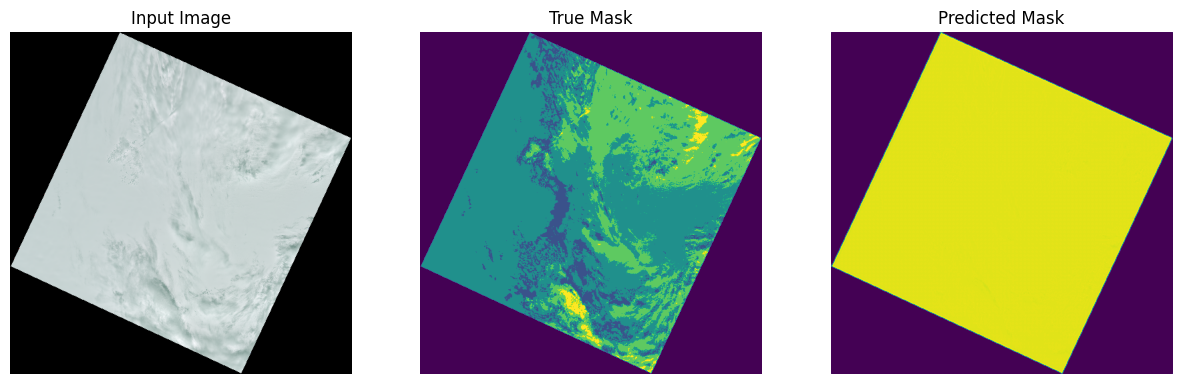

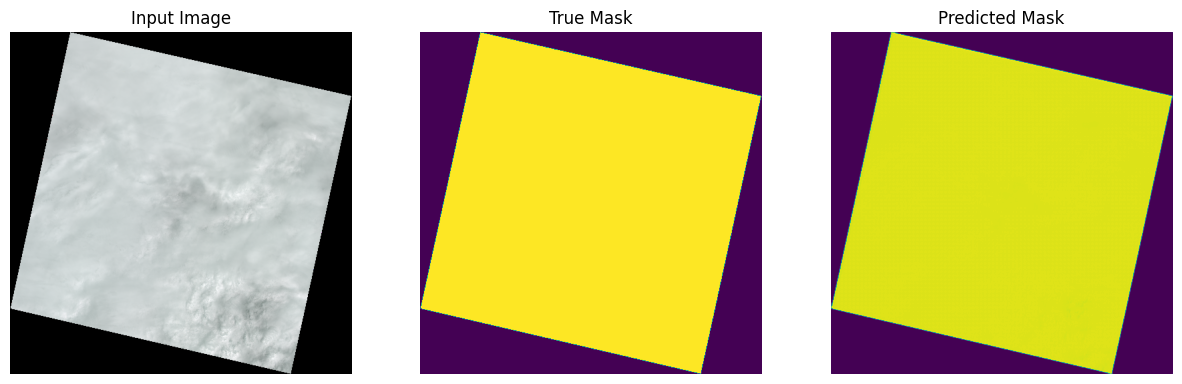

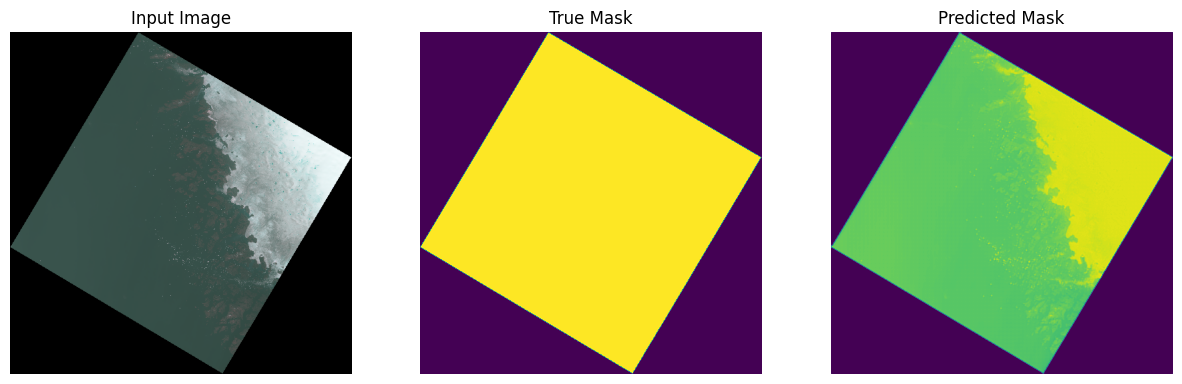

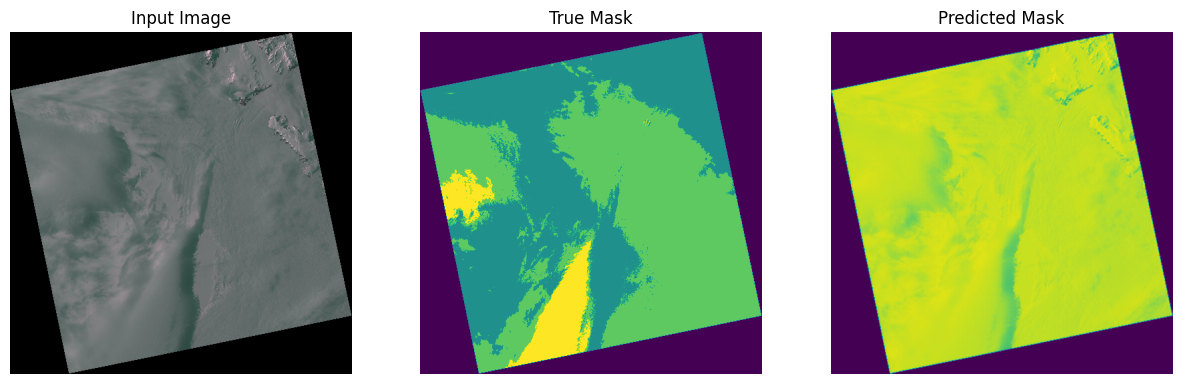

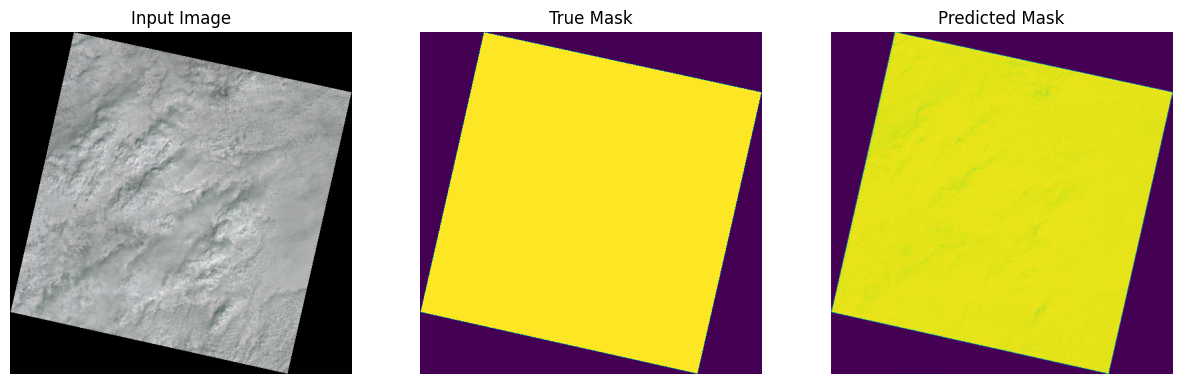

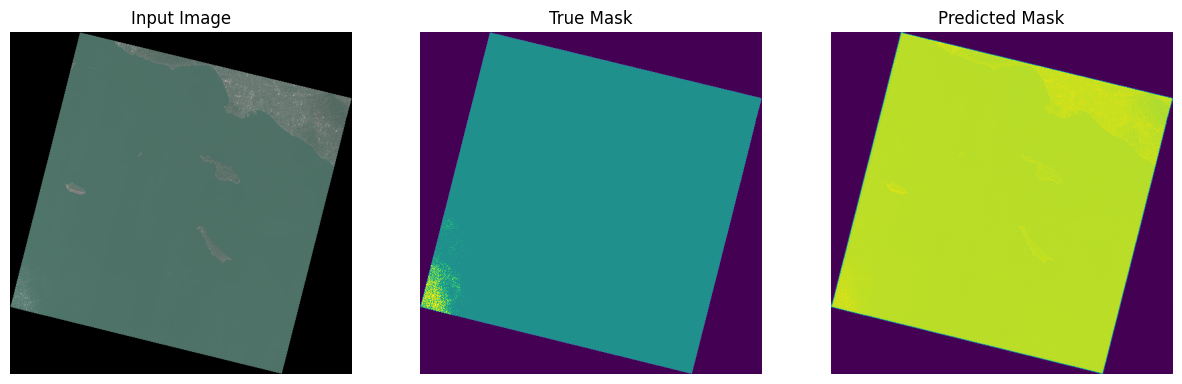

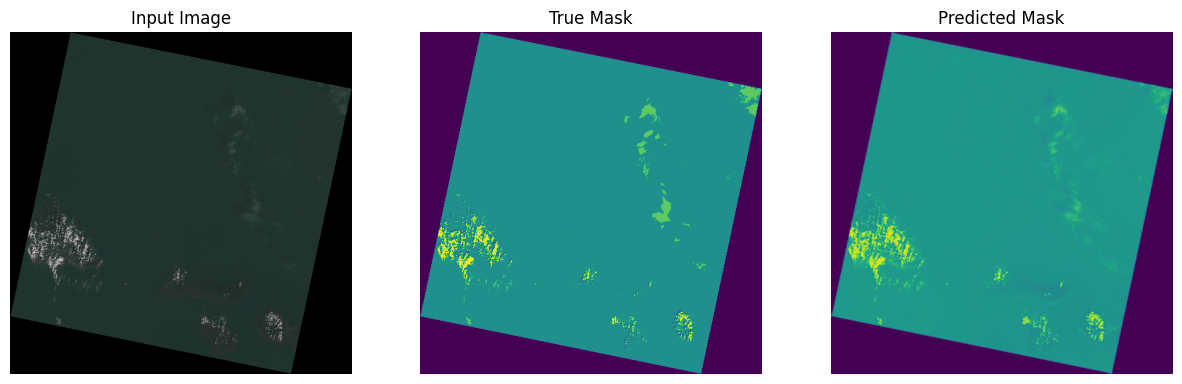

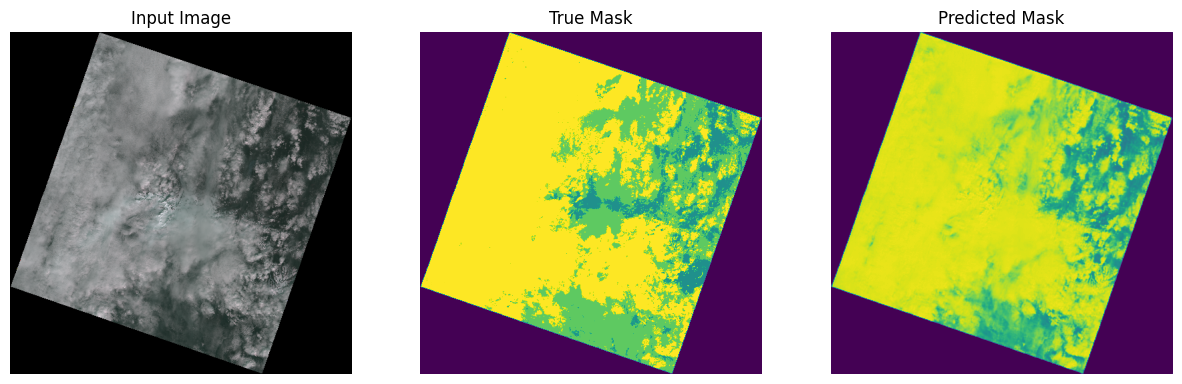

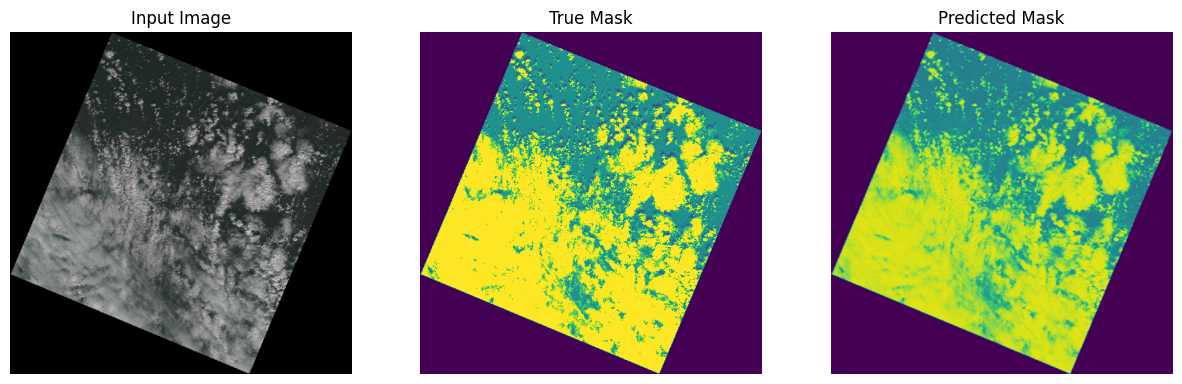

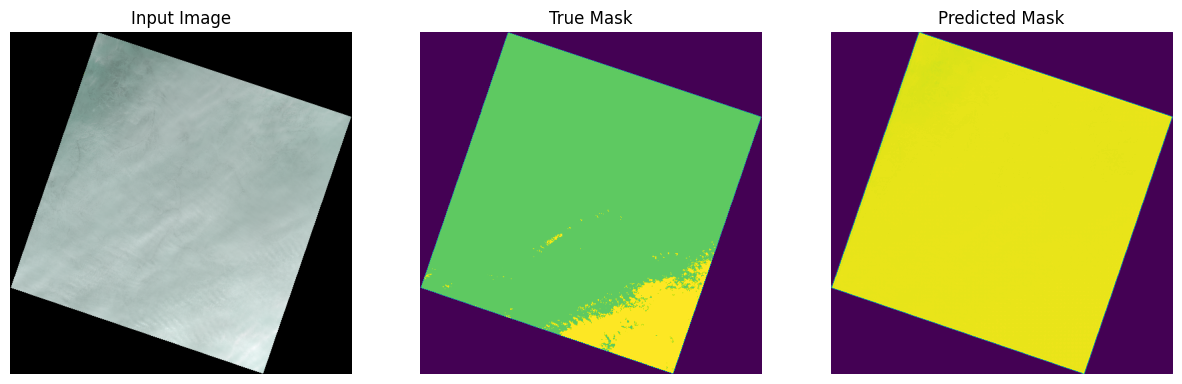

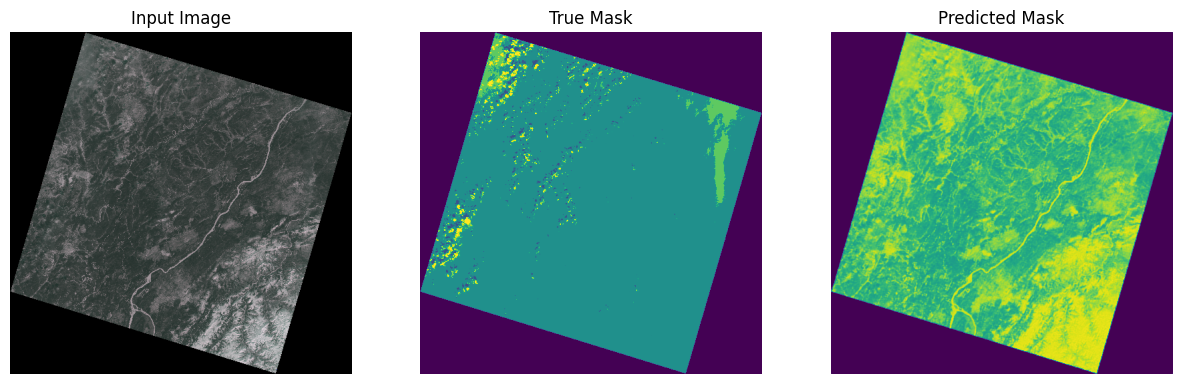

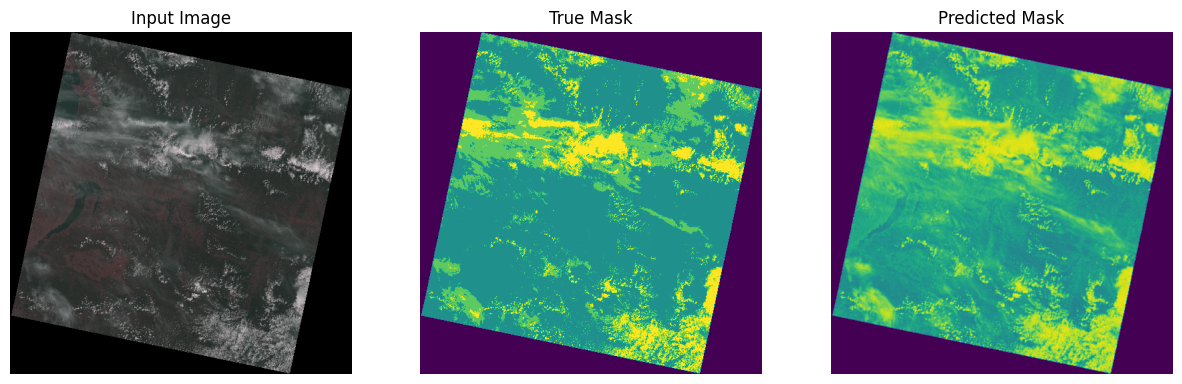

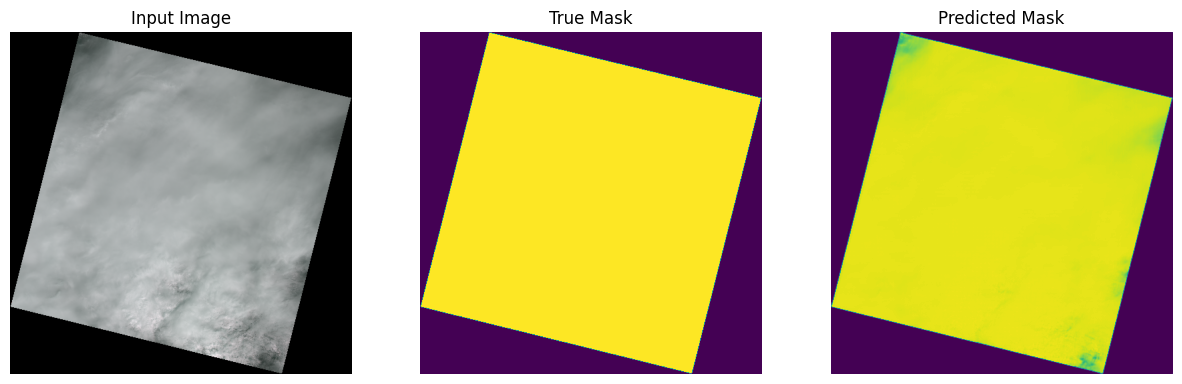

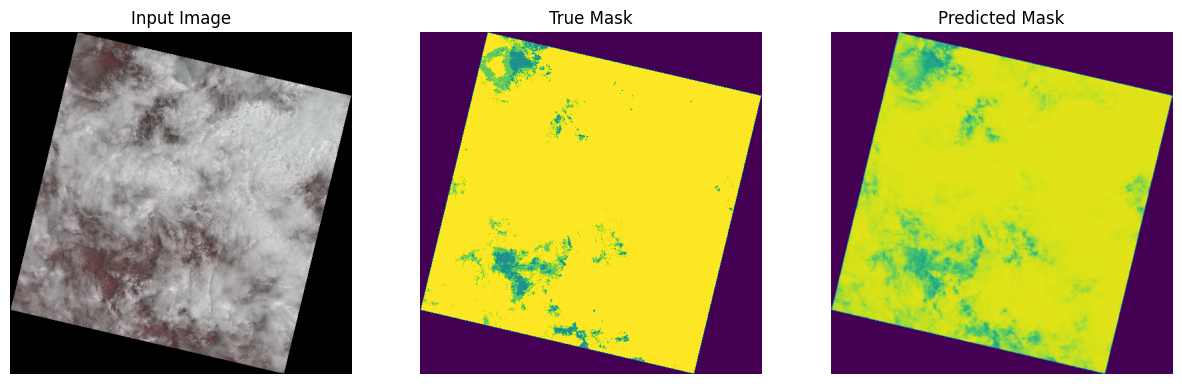

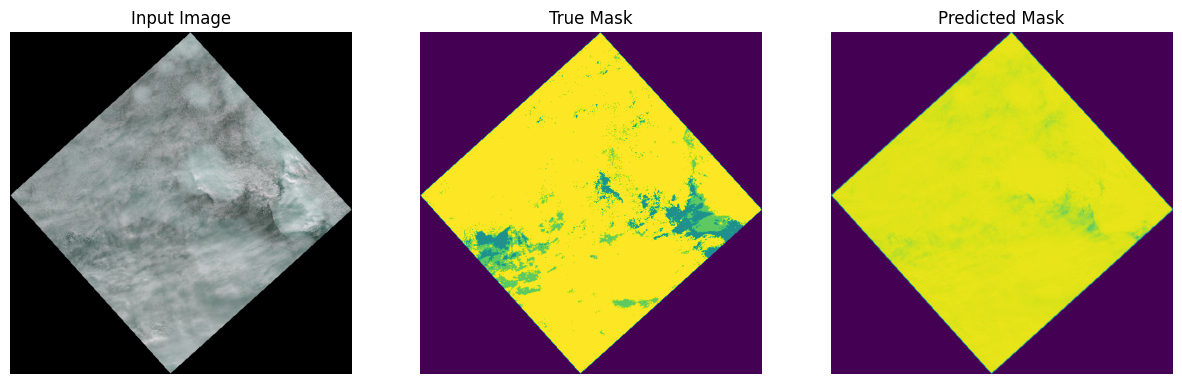

In [167]:
for i in range(qnt_images):
    b, g, r    = batch_test_images[i][:, :, 1], batch_test_images[i][:, :, 2], batch_test_images[i][:, :, 3]
    rgb = np.dstack((r,g,b))
    show_images([rgb, mask_true_image_test[i], mask_predict[i]])

# Aprendizado

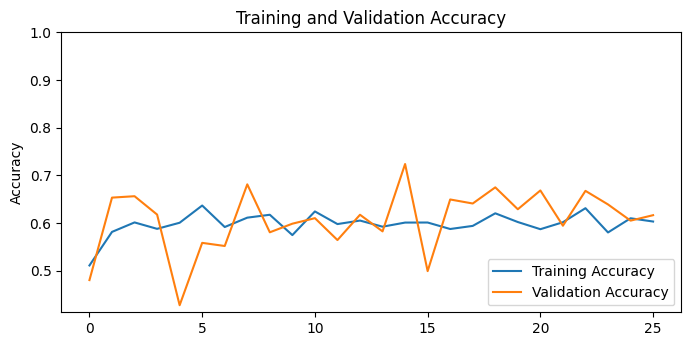

In [168]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.show()

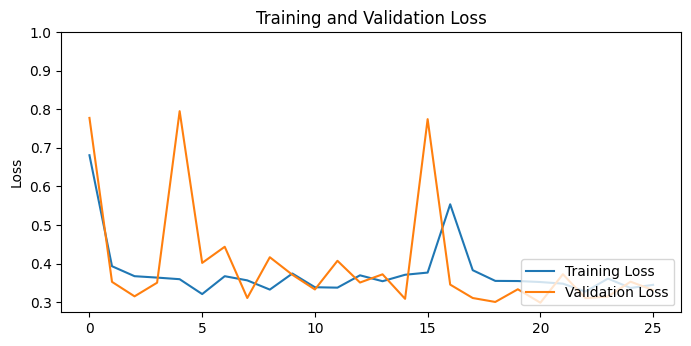

In [169]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')

plt.show()

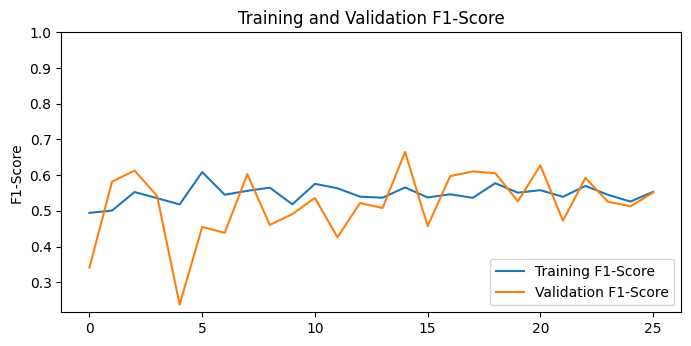

In [170]:
f1 = model_history.history['f1']
val_f1 = model_history.history['val_f1']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1, label='Training F1-Score')
plt.plot(val_f1, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.ylabel('F1-Score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1-Score')

plt.show()